In [1]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from tqdm import tqdm
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchviz import make_dot, make_dot_from_trace
from torch.utils.data import DataLoader, Dataset
import os

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=8, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=8)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=8)

In [4]:
len(training_dataset.classes)

102

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])


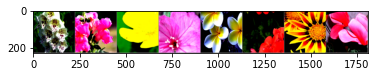

96 5 45 1 82 56 71 89


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(8)))

In [6]:
class ConvBlock(nn.Module):
    
    def __init__(self, input_dim, block_dim):
        super(ConvBlock, self).__init__()
        self.input_dim = input_dim
        self.output_dim = block_dim*4
        
        self.block = nn.Sequential(
            nn.Conv2d(input_dim,block_dim,1,bias=False),
            nn.Conv2d(block_dim,block_dim,3,padding=1,bias=False),
            nn.Conv2d(block_dim,self.output_dim,1,bias=False)
        )
        self.downsample = nn.Sequential(
            nn.Conv2d(input_dim, self.output_dim, 1,bias=False)
        )
        
    def forward(self, x):
        tmp = self.block(x)
        if self.input_dim != self.output_dim:
            res = self.downsample(x)
        else:
            res = x
        tmp = tmp + res
        return tmp

In [7]:
class ResNet(nn.Module):
    
    def __init__(self):
        super(ResNet, self).__init__()
        self.foot = nn.Sequential(
            nn.Conv2d(3,64,7,stride=2, padding = 3),
            nn.MaxPool2d(3,stride=2)
        )
        self.block1 = nn.Sequential(
            ConvBlock(64,64),
            ConvBlock(256,64),
            ConvBlock(256,64)
        )
        self.block2 = nn.Sequential(
            ConvBlock(256,128),
            ConvBlock(512,128),
            ConvBlock(512,128),
            ConvBlock(512,128),
            nn.MaxPool2d(2,2)
        )
        self.block3 = nn.Sequential(
            ConvBlock(512,256),
            ConvBlock(1024,256),
            ConvBlock(1024,256),
            ConvBlock(1024,256),
            ConvBlock(1024,256),
            ConvBlock(1024,256),
            nn.MaxPool2d(2,2)
        )
        self.block4 = nn.Sequential(
            ConvBlock(1024,512),
            ConvBlock(2048,512),
            ConvBlock(2048,512),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Linear(2048,102)
        )

        
    def forward(self, x):
        tmp = self.foot(x)
        tmp = self.block1(tmp)
        tmp = self.block2(tmp)
        tmp = self.block3(tmp)
        tmp = self.block4(tmp)
        tmp = torch.flatten(tmp,start_dim=1)
        tmp = self.fc(tmp)

        return tmp

In [17]:
model = ResNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or Cuda
model.to(device)

The model will be running on cuda:0 device


ResNet(
  (foot): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (downsample): Sequential(
        (0): Conv2d(256, 256, kerne

In [18]:
model(torch.randn(8,3,224,224)).shape

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
epoches = 1

In [21]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    for data in tqdm(train_loader):
        img, label = data
        img = img.cuda()
        label = label.cuda()
        
        output = model(img)
        
        optimizer.zero_grad()
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
            
        running_loss += loss.item()
    training_loss.append(running_loss/len(train_loader))
    print(f'epoch {e+1}: {running_loss/len(train_loader)}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 819/819 [01:31<00:00,  8.92it/s]

epoch 1: 1.6942445242051492e+19


In [ ]:
for data in tqdm(train_loader):
        img, label = data
        print(img.shape)
        break